In [ ]:
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import pickle
import matplotlib.pyplot as plt
from torchvision.transforms import functional as tvf

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")    # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class PascalVoc2012dataset:
    def __init__(self,train_path,label_path,transforms=None):
        self.img_dir=train_path
        self.lab_dir=label_path
        temp1=os.listdir(self.img_dir)
        temp2=os.listdir(self.lab_dir)
        self.images=[]
        self.labels=[]
        self.images_train=[]
        self.images_train_val=[]
        self.images_val=[]
        self.labels_train=[]
        self.labels_train_val=[]
        self.labels_val=[]
        self.transforms=transforms
        for i in temp1:
            self.images.append(i)
        for j in temp2:
            self.labels.append(j)
        self.specific_image_dir={}
        self.specific_labels_dir={}
        self.specific_image_train_dir={}
        self.specific_image_train_val_dir={}
        self.specific_image_val_dir={}
        self.specific_labels_train_dir={}
        self.specific_labels_train_val_dir={}
        self.specific_labels_val_dir={}
        for i,j in zip(self.images,range(len(self.images))):
            self.specific_image_dir[j]=os.path.join(self.img_dir,i)
        for k,l in zip(self.labels,range(len(self.labels))):
            self.specific_labels_dir[l]=os.path.join(self.lab_dir,k)
        self.pointer=0
            
    def __getitem__(self,index,type):
        if type=='image':
            image_path=self.specific_image_dir[index]
            img=cv2.imread(image_path,1)#to read image in grayscale
        if type=='label':
            image_path=self.specific_labels_dir[index]
            img=cv2.imread(image_path,1)#to read image in grayscale

        if self.transforms:
            img=self.transforms(img)
            return img
        else:
            return img
    def __len__(self):
        return len(self.images)

    def get_next_batch(batch_image,pointer):
        pointer+=1
        return (batch_image[pointer,:],pointer)
    
    #def making_mini_batches(self,dataset_images,dataset_labels,batch_size):
        #m,h,w,c=dataset_images.shape
        #batched_images_dataset=torch.zeros((int((dataset_images.shape[0])/batch_size),batch_size,h,w,c))
        #batched_labels_dataset=torch.zeros((int((dataset_images.shape[0])/batch_size),batch_size,h,w,c))
        #for j in range(batch_size):
            #if dataset_images.shape[0]%batch_size==0:
                #for i in (range(dataset_images.shape[0])):
                    #batched_images_dataset[j,(i%batch_size),:]=dataset_images[i]
                    #batched_labels_dataset[j,(i%batch_size),:]=dataset_labels[i]
                    #if i%batch_size==0:
                         #break
           # else:
                #Print("error Batch size not divisble by size of mini_batches")
        #return (batched_images_dataset,batched_labels_dataset)
    
    def training_val_sample(self,train_file_dir,val_dir):
        train_file_list=[]
        train_file_labels_list=[]
        train_val_list=[]
        train_val_labels_list=[]
        val_list=[]
        val_labels_list=[]
        with open(train_file_dir,"r") as obj1:
            for f in obj1:
                f1=f.rstrip("\n")+".jpg"
                f2=f.rstrip("\n")+".png"
                train_file_list.append([f1,f2])
        with open(val_dir,"r") as obj3:
            for f in obj3:
                f1=f.rstrip("\n")+".jpg"
                f2=f.rstrip("\n")+".png"
                val_list.append([f1,f2])
        self.images_train=train_file_list
        self.images_train_val=train_val_list
        self.images_val=val_list
        
        
    def preprocess_labels(self,labels):
      boolean_true=(labels>=125)
      boolean_false=(labels<125)
      labels[boolean_true]=255
      labels[boolean_false]=0
      labels=labels/255.0
      return labels


  
    def getting_next_batch(self,train_file_dir,val_dir,reset=None):
        if reset==True:
            self.pointer=0
        self.training_val_sample(train_file_dir,val_dir)
        color_op=torchvision.transforms.ColorJitter(0.1,0.1,0.1)
        tensor_op=torchvision.transforms.ToTensor()
        train_image=torch.zeros((10,3,224,224))
        train_labels=torch.zeros((10,1,224,224)) 
        for i in range(self.pointer,self.pointer+1):
            image=Image.open(os.path.join(self.img_dir,(self.images_train[i])[0]))
            labels=(cv2.imread(os.path.join(self.lab_dir,(self.images_train[i])[1]),0))
            labels=self.preprocess_labels(labels)
            labels=Image.fromarray(labels)
            if image.size[0]<224 or image.size[1]<224:
              image=image.resize((300,300))
              labels=labels.resize((300,300))
            #print(np.array(image).shape)
            ten_crop=tvf.five_crop(image,224)
            #labels=self.preprocess_labels(labels)
            #labels=np.expand_dims(labels,axis=2)
            
            ten_crop_labels=tvf.five_crop(labels,224)
            train_image=ten_crop
            train_labels=ten_crop_labels
            
        self.pointer+=1
        return (train_image,train_labels)
  

In [ ]:
dataset=PascalVoc2012dataset("/content/drive/My Drive/NNFL_project/VOC2012/JPEGImages","/content/drive/My Drive/NNFL_project/improved_contours")

In [ ]:
print(dataset)

In [ ]:
train,train_labels=dataset.getting_next_batch(r"/content/drive/My Drive/train1.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/val.txt")

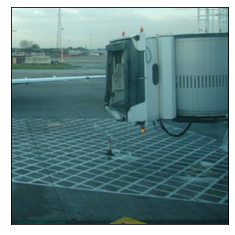

In [ ]:
#print(train_labels.shape)
plt.imshow(train[3], interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
model=torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
list(model.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace=True)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace=True)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace=True)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace=True)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace=True)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace=True)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(

In [ ]:
class Encoder(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.vgg=list(model.children())[0]
        self.vgg1=list(model.children())[2][0]
        self.conv6=nn.Conv2d(in_channels=4096,out_channels=512,kernel_size=1,stride=1)
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.pool5=nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
    def forward(self,t):
        #t=(t/255.0) #normalizing inputs
        #layer1
        t=self.vgg[0](t)
        t=self.vgg[1](t)
        t=self.vgg[2](t)
        t=self.vgg[3](t)
        t,indices1=self.pool1(t)

        
        #layer 2
        t=self.vgg[5](t)
        t=self.vgg[6](t)
        t=self.vgg[7](t)
        t=self.vgg[8](t)
        t,indices2=self.pool2(t)
        
        #layer 3
        t=self.vgg[10](t)
        t=self.vgg[11](t)
        t=self.vgg[12](t)
        t=self.vgg[13](t)
        t=self.vgg[14](t)
        t=self.vgg[15](t)
        t,indices3=self.pool3(t)
        
        #layer 4
        t=self.vgg[17](t)
        t=self.vgg[18](t)
        t=self.vgg[19](t)
        t=self.vgg[20](t)
        t=self.vgg[21](t)
        t=self.vgg[22](t)
        t,indices4=self.pool4(t)
      
        #layer 5
        
        t=self.vgg[24](t)
        t=self.vgg[25](t)
        t=self.vgg[26](t)
        t=self.vgg[27](t)
        t=self.vgg[28](t)
        t=self.vgg[29](t)
        
        #layer 6
        
        t,indices5=self.pool5(t)
        t=t.flatten(start_dim=1)
        t=self.vgg1(t)
        
        # last convolutional layer
        #or can be done directly using for loops
        t=(t.unsqueeze(1)).unsqueeze(1).reshape(t.shape[0],t.shape[1],1,1)
        
        indices=[indices1,indices2,indices3,indices4,indices5]
        
        return t,indices
    
class Decoder(nn.Module):

    def __init__(self,model):
        super().__init__()
        self.conv6=nn.Conv2d(in_channels=4096,out_channels=512,kernel_size=1,stride=1)
        self.deconv6=nn.ConvTranspose2d(in_channels=512,out_channels=512,kernel_size=7)
        self.deconv5=nn.ConvTranspose2d(in_channels=512,out_channels=512,kernel_size=5,padding=2)
        self.deconv4=nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=5,padding=2)
        self.deconv3=nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=5,padding=2)
        self.deconv2=nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=5,padding=2)
        self.deconv1=nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=5,padding=2)
        self.deconv0=nn.ConvTranspose2d(in_channels=32,out_channels=1,kernel_size=5,padding=2)


    def forward(self,t,indices1,indices2,indices3,indices4,indices5):
        t=self.conv6(t)
        t=self.deconv6(t)
        t=F.relu(t)
        t=nn.MaxUnpool2d(kernel_size=2,stride=2)(t,indices5)
        t=F.relu(t)
        t=self.deconv5(t)
        t=F.relu(t)
        t=nn.MaxUnpool2d(kernel_size=2,stride=2)(t,indices4)
        t=F.relu(t)
        t=self.deconv4(t)
        t=F.relu(t)
        t=nn.MaxUnpool2d(kernel_size=2,stride=2)(t,indices3)
        t=F.relu(t)
        t=self.deconv3(t)
        t=F.relu(t)
        t=nn.MaxUnpool2d(kernel_size=2,stride=2)(t,indices2)
        t=F.relu(t)
        t=self.deconv2(t)
        t=F.relu(t)
        t=nn.MaxUnpool2d(kernel_size=2)(t,indices1)
        t=F.relu(t)
        t=self.deconv1(t)
        t=F.relu(t)
        t=self.deconv0(t)
        t=torch.sigmoid(t)
        return t
    

In [ ]:

class Encoder_Decoder(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.encoder=Encoder(model)
        self.decoder=Decoder(model)
    
    def forward(self,t):
        batch_size,h,w,c=t.shape
        t,self.indices=self.encoder.forward(t)
        t=self.decoder.forward(t,self.indices[0],self.indices[1],self.indices[2],self.indices[3],self.indices[4])
        t=t.reshape(batch_size,224,224,1)
        return t
        


In [ ]:
#network=Encoder_Decoder(model)

In [ ]:
network=torch.load("/content/drive/My Drive/model_semi_final_231.pth")

In [ ]:
network.to(device)

Encoder_Decoder(
  (encoder): Encoder(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [ ]:
optimizer=torch.optim.Adam([x for x in list(network.parameters()) if x.requires_grad == True],lr= 3e-4)
#batch_image1=train
#batch_image1.shape
#labels_image1=next(iter(train_labels))
#print(labels_image1.shape)

In [ ]:
def image_plot(preds):
    if (preds.shape)[3]==3:      
      plt.imshow(preds[2,:].detach().cpu().numpy(), interpolation = 'bicubic')
      plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
      plt.show()
    else:
      preds=torch.squeeze(preds)
      plt.imshow(preds[2,:].detach().cpu().numpy(), interpolation = 'bicubic')
      plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
      plt.show()


In [ ]:
class Loss:
  def __init__(self):
    self.bce=nn.BCELoss(reduction="none")
  def loss(self,predictions,targets):
    loss = self.bce(predictions,targets)
    mask = (targets==1)
    unmask = (targets==0)
    total_idx=loss.shape[0]*loss.shape[1]*loss.shape[2]*loss.shape[3]
    total_loss=(((10*loss[mask].sum())+1*loss[unmask].sum())/total_idx)
    return total_loss


In [ ]:
def convert_array(data,channels):
  new_data=np.zeros((5,224,224,channels))
  for i in range(5):
    if channels==1:
      new_data[i]=np.expand_dims(np.asarray(data[i]),axis=2)
    else:
      new_data[i]=np.asarray(data[i])
  return new_data

In [ ]:
network=network.double()

torch.Size([5, 224, 224, 3])
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], device='cuda:0', dtype=torch.float64)


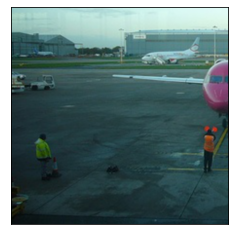

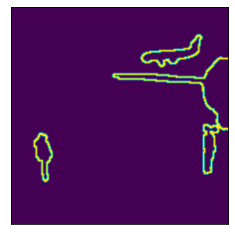

In [ ]:
train,train_labels=dataset.getting_next_batch(r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/train.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/val.txt",reset=True)
train=torch.from_numpy(np.asarray(convert_array(train,3))).to(device)
train_labels=torch.from_numpy(np.asarray(convert_array(train_labels,1))).to(device)
train=train/255.0
print(train.shape)
predictions=network(train.reshape(5,3,224,224))
lossobject=Loss()
#print(predictions.shape)
#print(train_labels.shape)
loss=F.binary_cross_entropy(predictions,train_labels)
#print(loss)
loss.backward()
optimizer.step()
#print(predictions[0,:])
print(train_labels[0,:])
#print(train[1,:])
image_plot(train)
image_plot(train_labels)

In [ ]:
lossobject=Loss()
total_loss=0

epoch 0 loss : 0


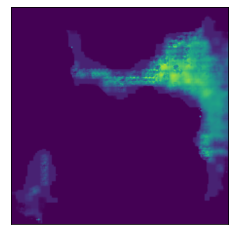

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


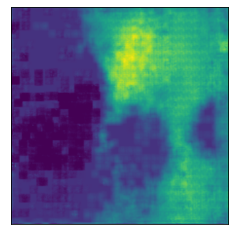

tensor(506.0313, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1

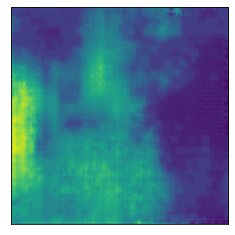

tensor(1016.2365, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184


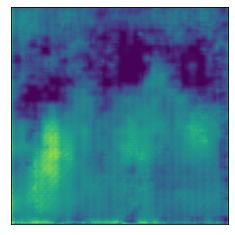

tensor(1540.3330, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184


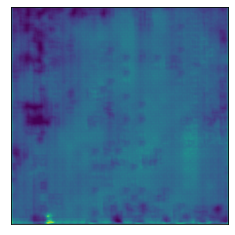

tensor(2069.4409, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184


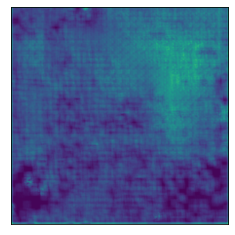

tensor(2608.6052, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184


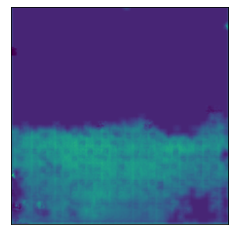

tensor(3166.7418, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184


In [ ]:
for epoch in range(10):
  print(f"epoch {epoch} loss : {total_loss}")
  total_loss=0
  image_plot(predictions)
  train,train_labels=dataset.getting_next_batch(r"/content/drive/My Drive/train1.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/val.txt",reset=True)
  train=torch.from_numpy(np.asarray(convert_array(train,3))).to(device)
  train_labels=torch.from_numpy(np.asarray(convert_array(train_labels,1))).to(device)
  train=train/255.0
  count=0
  for i in range(8000):
    count+=1
    print(count)
    optimizer.zero_grad()
    predictions=network(train.reshape(5,3,224,224))
    if count%1000==0:
      image_plot(predictions)
      print(total_loss)
    loss=lossobject.loss(predictions,train_labels)
    loss.backward()
    #clipping_value = 1  # arbitrary value of your choosing
    #torch.nn.utils.clip_grad_value_(network.decoder.parameters(), clipping_value)
    optimizer.step()
    total_loss+=loss
    train,train_labels=dataset.getting_next_batch(r"/content/drive/My Drive/train1.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/val.txt")
    train=torch.from_numpy(np.asarray(convert_array(train,3))).to(device)
    train_labels=torch.from_numpy(np.asarray(convert_array(train_labels,1))).to(device)
    train=train/255.0
  torch.save(network,f"/content/drive/My Drive/model_semi_final_2{epoch+32}.pth")

In [ ]:

print(total_loss)

In [ ]:

train,train_labels=dataset.getting_next_batch(r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/train.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/trainval.txt",r"/content/drive/My Drive/NNFL_project/Manan/VOC2012/ImageSets/Segmentation/val.txt",32,reset=True)
train=train.to(device)
train_labels=train_labels.to(device)
predictions=network(train.reshape(32,3,224,224))

In [ ]:
print(dataset.pointer)

In [ ]:
predictions.shape

In [ ]:
image_plot(train)
image_plot(predictions)

In [ ]:

network=torch.load("/content/drive/My Drive/model_infinity69.pth")

In [ ]:
img=cv2.imread("/content/drive/My Drive/3.jpg")
img=cv2.resize(img,(224,224))
print(img)
img=np.expand_dims(img,axis=3)
img=torch.from_numpy(img)
print(img.shape)

In [ ]:
#img=torch.from_numpy(img)

In [ ]:
img=img.to(device)

In [ ]:
predictions=network(img.reshape(1,3,224,224))

In [ ]:
 predictions[predictions>=0.5]=1
 predictions[predictions<0.5]=0

In [ ]:
predictions

In [ ]:
preds=predictions
if (preds.shape)[3]==3:
  plt.imshow(preds[0,:].detach().cpu().numpy(), interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()
else:
  preds=torch.squeeze(preds)
  plt.imshow(preds[:,:].detach().cpu().numpy(), interpolation = 'bicubic')
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()